<a href="https://colab.research.google.com/github/jameswilliam38/Time-Series-Forecasting/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precipitation forecasting with Long Short Term Memory (LSTM)

# Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


### Read Dataset dan Convert dataset ke bulanan

In [ ]:
jakBar = pd.read_csv("/content/gdrive/MyDrive/ProjekJakarta/CurahHujanJakbar2014-2024.csv")
jakBar.columns = ['Date', 'Precipitation']
jakBar['Date'] = pd.to_datetime(jakBar['Date'])
# Ubah data harian menjadi bulanan
jakBar.set_index('Date', inplace=True)
jakbar_bulanan = jakBar.resample('M').sum()
jakbar_bulanan.reset_index(inplace=True)

# Save ke CSV baru aja
jakbar_bulanan.to_csv('Precipitation_Bulanan_Jakbar.csv', index=False)

jakbar = pd.read_csv("/content/Precipitation_Bulanan_Jakbar.csv", index_col='Date', parse_dates=True)
print(jakbar)
jakbar.info()

            Precipitation
Date                     
2014-01-31        754.203
2014-02-28        514.129
2014-03-31        247.035
2014-04-30        197.551
2014-05-31        120.596
...                   ...
2023-12-31         49.395
2024-01-31        337.704
2024-02-29        267.375
2024-03-31        248.121
2024-04-30        130.738

[124 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2014-01-31 to 2024-04-30
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precipitation  124 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


## Cek decompose

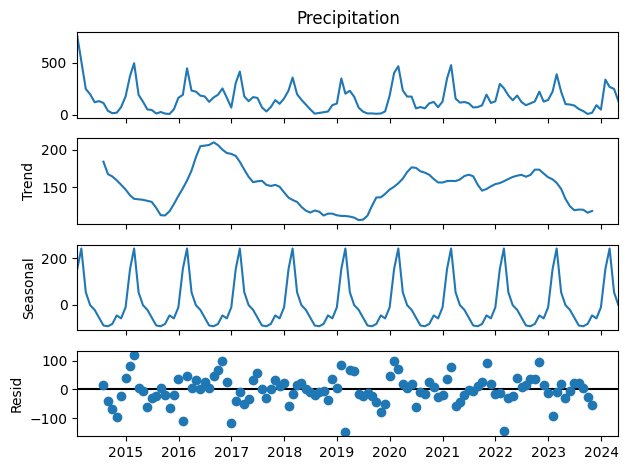

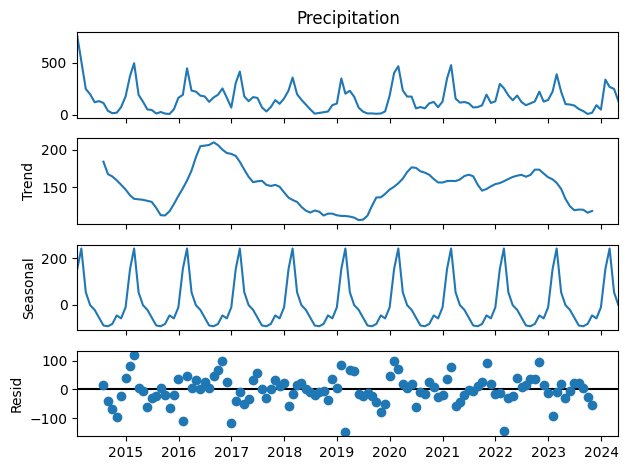

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(jakbar['Precipitation'], )
result.plot()

# Preprocessing
#### Preproses ada 3 tahap, remove outlier, smoothing data, train test split

## Removing Outliers pake IQR

In [ ]:
Q1 = jakbar['Precipitation'].quantile(0.25)
Q3 = jakbar['Precipitation'].quantile(0.75)

# Pakr IQR
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Tampilkan Outlier dri data
outliers = jakbar[(jakbar['Precipitation'] < lower_bound) | (jakbar['Precipitation'] > upper_bound)]

print("Outliers:")
print(outliers)

# Remove outliernya
jakbar_cleaned = jakbar[(jakbar['Precipitation'] >= lower_bound) & (jakbar['Precipitation'] <= upper_bound)]


print("Data after removing outliers:")
print(jakbar_cleaned)

Outliers:
            Precipitation
Date                     
2014-01-31        754.203
2014-02-28        514.129
2015-02-28        495.446
2016-02-29        446.295
2017-02-28        414.960
2020-01-31        402.366
2020-02-29        466.251
2021-02-28        476.425
Data after removing outliers:
            Precipitation
Date                     
2014-03-31        247.035
2014-04-30        197.551
2014-05-31        120.596
2014-06-30        131.269
2014-07-31        113.428
...                   ...
2023-12-31         49.395
2024-01-31        337.704
2024-02-29        267.375
2024-03-31        248.121
2024-04-30        130.738

[116 rows x 1 columns]


## Smoothing data menggunakan Simple Moving Average (SMA)

In [ ]:
# Window smoothing = 5
jakbar_cleaned['preci_smoothed'] = jakbar_cleaned['Precipitation'].rolling(window=5).mean()

# Isi nilai null hasil smoothing dengan mean
jakbar_cleaned['preci_smoothed'] = jakbar_cleaned['preci_smoothed'].fillna(jakbar_cleaned['preci_smoothed'].mean())

jakbar_cleaned.dropna(subset=['preci_smoothed'], inplace=True)

jakbar_cleaned = jakbar_cleaned.drop('Precipitation', axis = 1)

print(jakbar_cleaned)

            preci_smoothed
Date                      
2014-03-31      130.976923
2014-04-30      130.976923
2014-05-31      130.976923
2014-06-30      130.976923
2014-07-31      161.975800
...                    ...
2023-12-31       40.923000
2024-01-31      101.372800
2024-02-29      153.270000
2024-03-31      198.971400
2024-04-30      206.666600

[116 rows x 1 columns]


<ipython-input-114-1e823721655b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-1e823721655b>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-1e823721655b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Checking data

In [ ]:
print(jakbar_cleaned.columns)
jakbar_cleaned = jakbar_cleaned.rename(columns={'preci_smoothed': 'precipitation_smoothed'})
print(jakbar_cleaned)

Index(['preci_smoothed'], dtype='object')
            precipitation_smoothed
Date                              
2014-03-31              130.976923
2014-04-30              130.976923
2014-05-31              130.976923
2014-06-30              130.976923
2014-07-31              161.975800
...                            ...
2023-12-31               40.923000
2024-01-31              101.372800
2024-02-29              153.270000
2024-03-31              198.971400
2024-04-30              206.666600

[116 rows x 1 columns]


## Train Test split, pake Pareto Principle

In [ ]:
train_size = int(len(jakbar_cleaned) * 0.80)
train = jakbar_cleaned.iloc[:train_size]
test = jakbar_cleaned.iloc[train_size:]

In [ ]:
train

,precipitation_smoothed
Date,
2014-03-31,130.976923
2014-04-30,130.976923
2014-05-31,130.976923
2014-06-30,130.976923
2014-07-31,161.975800
...,...
2021-12-31,120.287600
2022-01-31,164.709000
2022-02-28,197.612600


## Scaling menggunakan MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Cek format data
jakbar_cleaned.head(), jakbar_cleaned.tail()

(            precipitation_smoothed
 Date                              
 2014-03-31              130.976923
 2014-04-30              130.976923
 2014-05-31              130.976923
 2014-06-30              130.976923
 2014-07-31              161.975800,
             precipitation_smoothed
 Date                              
 2023-12-31                 40.9230
 2024-01-31                101.3728
 2024-02-29                153.2700
 2024-03-31                198.9714
 2024-04-30                206.6666)

In [ ]:
# skalarkan data
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

array([[0.57022699],
       [0.57022699],
       [0.57022699],
       [0.57022699],
       [0.72351527],
       [0.51673969],
       [0.33658877],
       [0.2367025 ],
       [0.17921434],
       [0.24105605],
       [0.57285413],
       [0.74715615],
       [0.85314549],
       [0.8310425 ],
       [0.70277709],
       [0.3452919 ],
       [0.18225154],
       [0.0681673 ],
       [0.02565941],
       [0.03128084],
       [0.18042982],
       [0.34291733],
       [0.56107227],
       [0.77359192],
       [0.90399949],
       [0.91728858],
       [0.85089059],
       [0.7859929 ],
       [0.75614115],
       [0.82441427],
       [0.81254735],
       [0.7582655 ],
       [0.89674819],
       [0.88023696],
       [0.75934746],
       [0.76493329],
       [0.85672465],
       [0.62369132],
       [0.48152562],
       [0.42519458],
       [0.39666413],
       [0.34073462],
       [0.42564458],
       [0.62465262],
       [0.90570253],
       [0.96156281],
       [1.        ],
       [0.941

In [ ]:
# Time Series Generator untuk proses modelling
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Time Series Generator untuk proses modelling
from keras.preprocessing.sequence import TimeseriesGenerator
# Input = 12 menandakan ambil 12 bulan data untuk prediksi 1 bulan berikutnya
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X, y = generator[0]
print(f'INPUT ARRAY: \n{X.flatten()}' )
print(f'OUTPUT PREDICTED: {y}' )

INPUT ARRAY: 
[0.57022699 0.57022699 0.57022699 0.57022699 0.72351527 0.51673969
 0.33658877 0.2367025  0.17921434 0.24105605 0.57285413 0.74715615]
OUTPUT PREDICTED: [[0.85314549]]


In [ ]:
X.shape

(1, 12, 1)

## Modelling

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(55, activation="tanh", input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 55)                12540     
                                                                 
 dense_3 (Dense)             (None, 1)                 56        
                                                                 
Total params: 12596 (49.20 KB)
Trainable params: 12596 (49.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Fit generator ke model

In [ ]:
model.fit(generator, epochs=10)

Epoch 1/10
80/80 [==============================] - 4s 10ms/step - loss: 0.1142
Epoch 2/10
80/80 [==============================] - 1s 10ms/step - loss: 0.0810
Epoch 3/10
80/80 [==============================] - 1s 11ms/step - loss: 0.0751
Epoch 4/10
80/80 [==============================] - 1s 12ms/step - loss: 0.0544
Epoch 5/10
80/80 [==============================] - 1s 13ms/step - loss: 0.0346
Epoch 6/10
80/80 [==============================] - 1s 14ms/step - loss: 0.0245
Epoch 7/10
80/80 [==============================] - 1s 18ms/step - loss: 0.0188
Epoch 8/10
80/80 [==============================] - 1s 17ms/step - loss: 0.0183
Epoch 9/10
80/80 [==============================] - 1s 9ms/step - loss: 0.0154
Epoch 10/10
80/80 [==============================] - 1s 8ms/step - loss: 0.0136


#### Tampilan loss per epoch

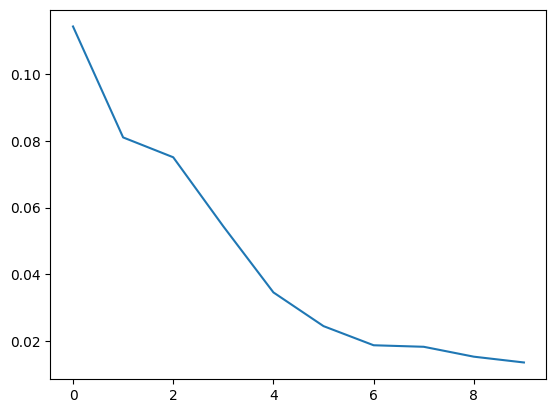

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]
print(last_train_batch)

[[0.783199  ]
 [0.76717435]
 [0.49257959]
 [0.41166022]
 [0.38636476]
 [0.45618368]
 [0.45891231]
 [0.51736869]
 [0.73703085]
 [0.89973792]
 [0.89181114]
 [0.91765648]]


In [ ]:
last_train_batch = last_train_batch.reshape(1, n_input, n_features)

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 1s 529ms/step


array([[0.7959611]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.97266622])

## Prediksi sebanyak test

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 35ms/step


In [ ]:
test_predictions

[array([0.7959611], dtype=float32),
 array([0.65538603], dtype=float32),
 array([0.50828147], dtype=float32),
 array([0.3927704], dtype=float32),
 array([0.3356049], dtype=float32),
 array([0.35102525], dtype=float32),
 array([0.43602067], dtype=float32),
 array([0.5728888], dtype=float32),
 array([0.7243624], dtype=float32),
 array([0.83879715], dtype=float32),
 array([0.878637], dtype=float32),
 array([0.8377606], dtype=float32),
 array([0.7335872], dtype=float32),
 array([0.5994393], dtype=float32),
 array([0.46956283], dtype=float32),
 array([0.37480953], dtype=float32),
 array([0.33781508], dtype=float32),
 array([0.3687549], dtype=float32),
 array([0.46228606], dtype=float32),
 array([0.5957491], dtype=float32),
 array([0.73031217], dtype=float32),
 array([0.82209647], dtype=float32),
 array([0.84263444], dtype=float32),
 array([0.79095346], dtype=float32)]

In [ ]:
test.shape

(24, 1)

#### Ubah prediksi dari skalar menjadi data normal

In [ ]:
predictions = scaler.inverse_transform(test_predictions)

### Tampilan data asli yang sudah di smoothing dengan prediksinya

In [ ]:
# Masukan hasil prediksi ke column baru dengan nama 'Prediction'
test['Prediction'] = predictions
print(test)

            precipitation_smoothed  Prediction
Date                                          
2022-05-31                212.3606  176.626226
2022-06-30                177.5528  148.198295
2022-07-31                144.8274  118.449928
2022-08-31                129.7344   95.090589
2022-09-30                127.3424   83.530238
2022-10-31                134.8544   86.648633
2022-11-30                135.7728  103.836916
2022-12-31                145.8158  131.515209
2023-01-31                168.3746  162.147105
2023-02-28                220.5638  185.288793
2023-03-31                220.2832  193.345449
2023-04-30                215.5042  185.079181
2023-05-31                206.7784  164.012606
2023-06-30                179.9732  136.884417
2023-07-31                113.4046  110.620013
2023-08-31                 76.2690   91.458433
2023-09-30                 57.3092   83.977192
2023-10-31                 41.5178   90.234027
2023-11-30                 42.2110  109.148460
2023-12-31   

<ipython-input-139-2386f7dba661>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plotting

In [ ]:
test = test.reset_index()
print(test)

         Date  precipitation_smoothed  Prediction
0  2022-05-31                212.3606  176.626226
1  2022-06-30                177.5528  148.198295
2  2022-07-31                144.8274  118.449928
3  2022-08-31                129.7344   95.090589
4  2022-09-30                127.3424   83.530238
5  2022-10-31                134.8544   86.648633
6  2022-11-30                135.7728  103.836916
7  2022-12-31                145.8158  131.515209
8  2023-01-31                168.3746  162.147105
9  2023-02-28                220.5638  185.288793
10 2023-03-31                220.2832  193.345449
11 2023-04-30                215.5042  185.079181
12 2023-05-31                206.7784  164.012606
13 2023-06-30                179.9732  136.884417
14 2023-07-31                113.4046  110.620013
15 2023-08-31                 76.2690   91.458433
16 2023-09-30                 57.3092   83.977192
17 2023-10-31                 41.5178   90.234027
18 2023-11-30                 42.2110  109.148460


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test['Date'], y=test['precipitation_smoothed'], mode='lines', name='Actual'))


fig.add_trace(go.Scatter(x=test['Date'], y=test['Prediction'], mode='lines', name='Forecast'))

# Update layout with title and axis labels
fig.update_layout(title="Perbandingan data curah Hujan Jakarta Barat dengan hasil forecast curah hujan Jakarta Barat (LSTM)", xaxis_title="Tanggal", yaxis_title="Curah Hujan")
fig.show()

In [ ]:
test['Prediction']

0     176.626226
1     148.198295
2     118.449928
3      95.090589
4      83.530238
5      86.648633
6     103.836916
7     131.515209
8     162.147105
9     185.288793
10    193.345449
11    185.079181
12    164.012606
13    136.884417
14    110.620013
15     91.458433
16     83.977192
17     90.234027
18    109.148460
19    136.138153
20    163.350309
21    181.911480
22    186.064792
23    175.613554
Name: Prediction, dtype: float64

## Evaluasi menggunakan Root Mean Square Error (RMSE)

In [ ]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

rmse_value = rmse(test['precipitation_smoothed'], test['Prediction'])
print("Root Mean Squared Error between actual and  predicted values: ", rmse_value)

mape_value = mean_absolute_percentage_error(test['precipitation_smoothed'], test['Prediction'])
print("Mean Absolute Percentage Error between actual and predicted values for Prophet: ", mape_value)

Root Mean Squared Error between actual and  predicted values:  40.19959945570333
Mean Absolute Percentage Error between actual and predicted values for Prophet:  0.3963528416611916
